In [1]:
import warnings
import os
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Importing necessary libraries
import cv2
import mediapipe as mp
import os
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

2024-07-06 13:54:53.658693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 13:54:53.787338: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 13:54:53.788034: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

# Initializing MediaPipe Hand model
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

# Function to extract landmarks from an image
def extract_landmarks(image_path):
    image = cv2.imread(image_path)
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        # Extract landmarks
        landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.multi_hand_landmarks[0].landmark]).flatten()
        return landmarks
    return None


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1720254303.391859    3449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1720254303.417060    3449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [4]:

# Loading dataset and extract features
X = []  # Features
y = []  # Labels

dataset_path = 'split_asl_dataset'
for subset in ['train', 'test', 'val']:
    subset_path = os.path.join(dataset_path, subset)
    for label in os.listdir(subset_path):
        class_path = os.path.join(subset_path, label)
        for image_name in tqdm(os.listdir(class_path), desc=f'{label} Images', leave=False):
            image_path = os.path.join(class_path, image_name)
            landmarks = extract_landmarks(image_path)
            if landmarks is not None:
                X.append(landmarks)
                y.append(label)


In [9]:
import os
os.getcwd()

'/mnt/d/NullClass_Internship/Action_Detection/Static_Detection'

In [10]:
# Converting lists to numpy arrays
X_np = np.array(X)
y_np = np.array(y)

# Saving to files
np.save('saved_features/features.npy', X_np)
np.save('saved_features/labels.npy', y_np)

In [12]:

# Encoding labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=48)


In [13]:
# Initializing and training MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
mlp.fit(X_train, y_train)

MLPClassifier(max_iter=500)

In [14]:
# Evaluating the model
accuracy = mlp.score(X_test, y_test)
print(f"Model accuracy: {accuracy*100:.2f}%")

Model accuracy: 93.85%


In [15]:
from joblib import dump
dump(mlp, 'mlp_model.joblib')

['mlp_model.joblib']

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = mlp.predict(X_test)



In [18]:
p = y_pred
y = y_test
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 305
Incorrect predicted classes: 20


In [19]:

# Dictionary to save all the 36 classes
categories = {i: str(i) for i in range(10)}  # For numbers 0-9
categories.update({10 + i: chr(97 + i) for i in range(26)})  # For letters a-z

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=list(categories.values()), labels=list(categories.keys())))


              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       1.00      1.00      1.00        10
           2       0.60      0.60      0.60        10
           3       1.00      1.00      1.00        13
           4       0.91      0.95      0.93        21
           5       0.90      0.82      0.86        11
           6       0.83      0.71      0.77         7
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        13
           a       1.00      1.00      1.00         2
           b       1.00      1.00      1.00        14
           c       1.00      0.85      0.92        13
           d       1.00      1.00      1.00        14
           e       1.00      1.00      1.00         2
           f       0.94      1.00      0.97        15
           g       1.00      1.00      1.00         9
           h       1.00    

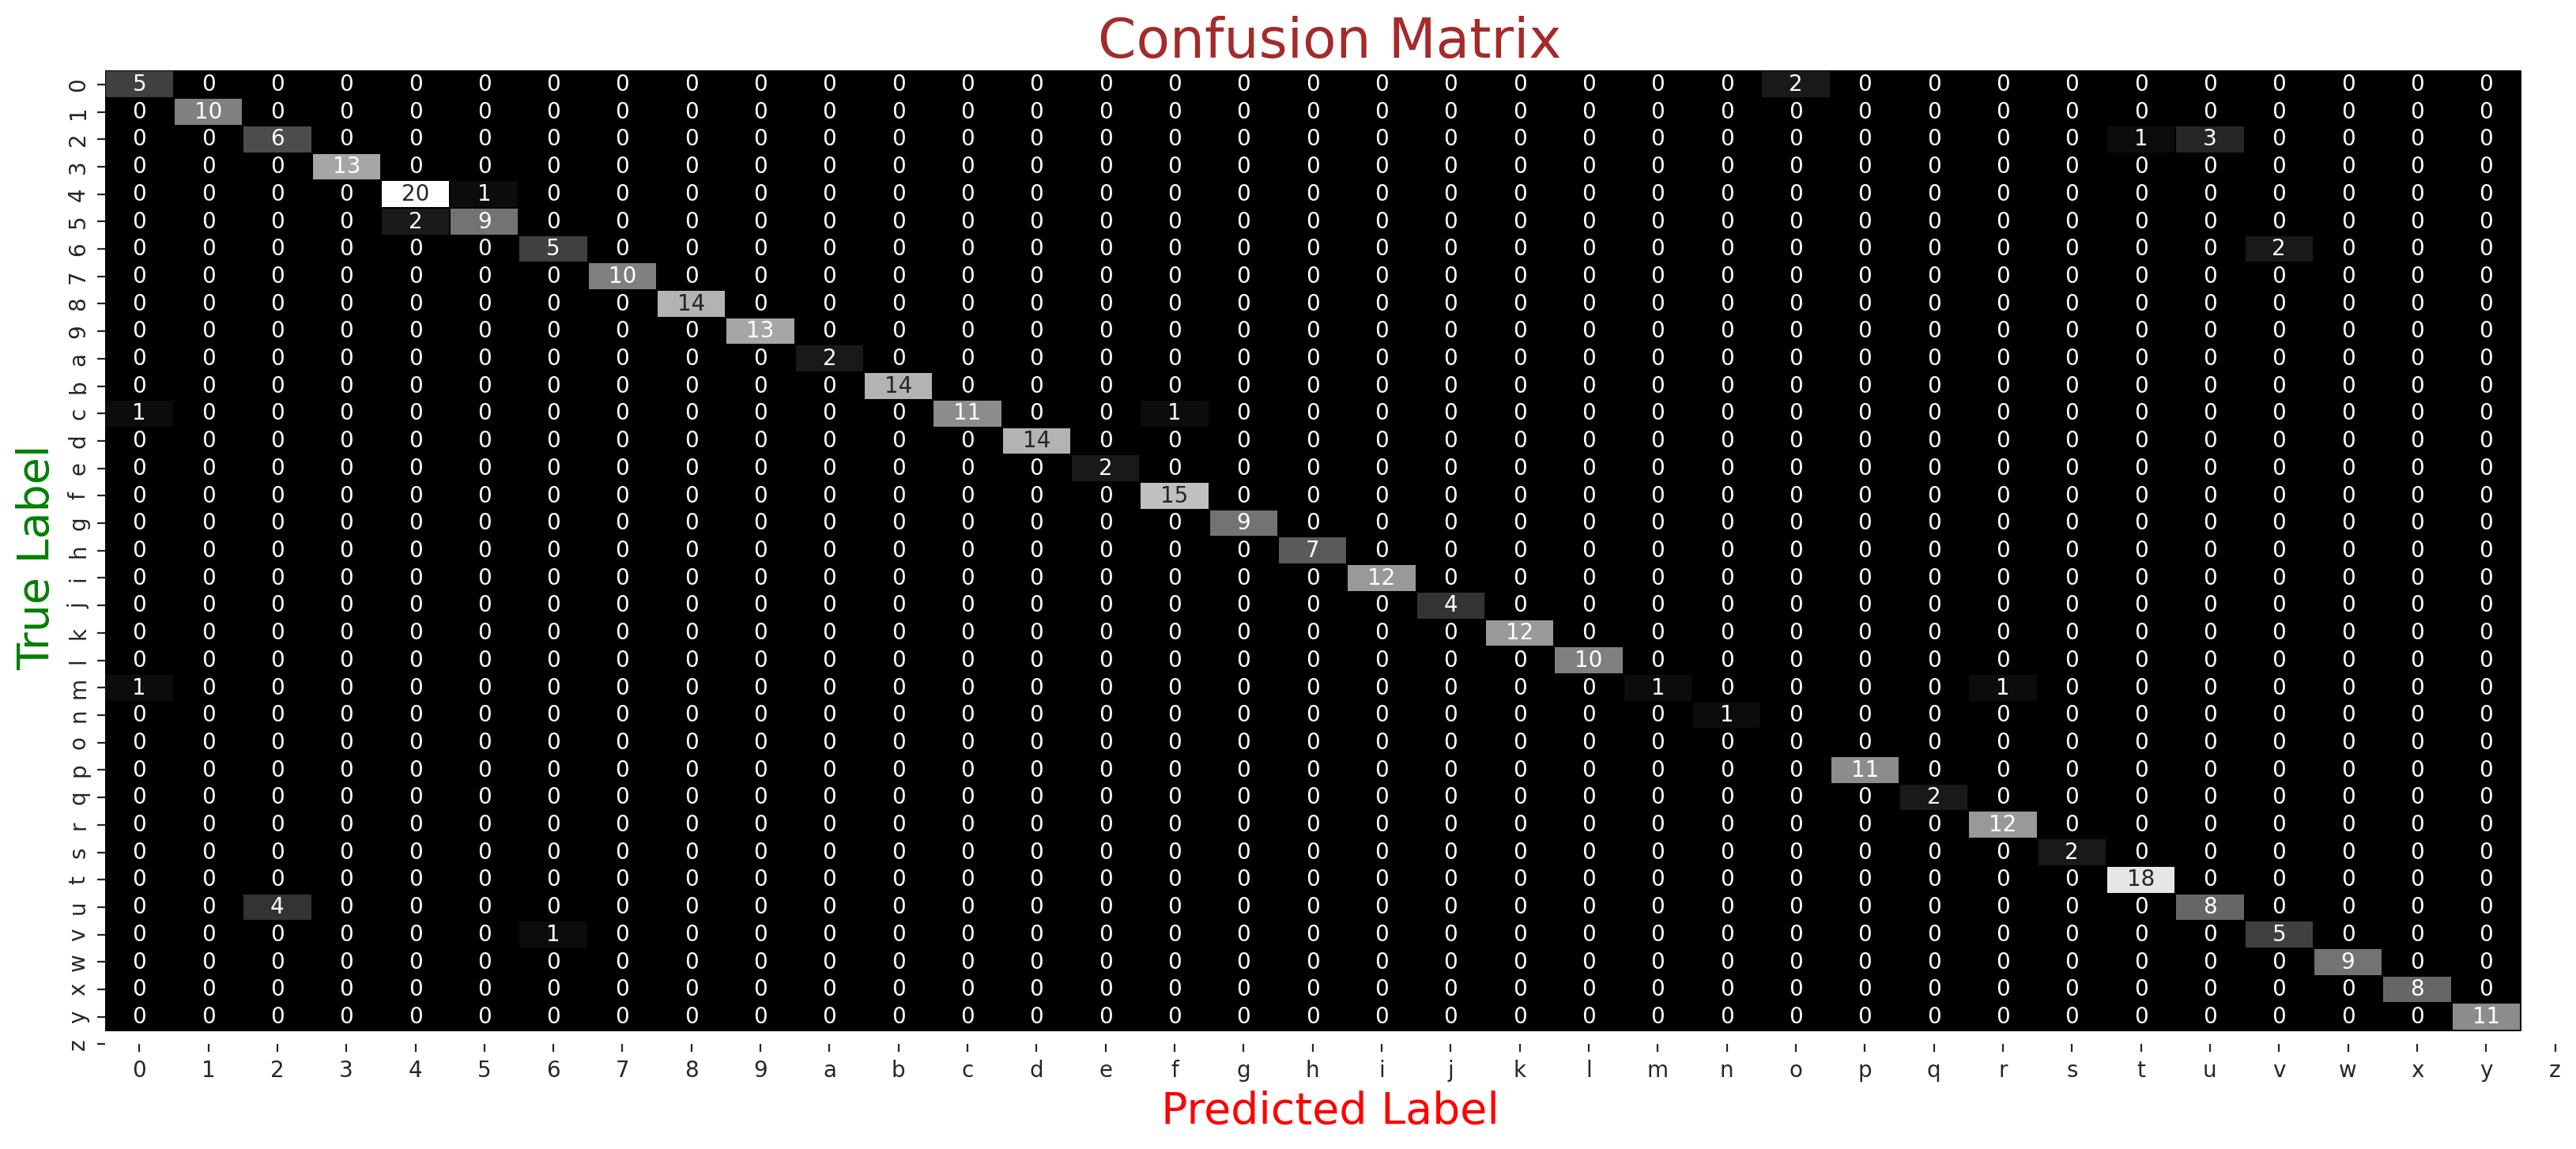

In [22]:
sns.set_style('ticks')

confusion_mtx = confusion_matrix(y_test, y_pred) 

f,ax = plt.subplots(figsize = (20,8),dpi=200)

sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.1, cmap = "gist_yarg_r", 
            linecolor="black", fmt='.0f', ax=ax, 
            cbar=False, xticklabels=categories.values(), 
            yticklabels=categories.values())

plt.xlabel("Predicted Label",fontdict={'color':'red','size':20})
plt.ylabel("True Label",fontdict={'color':'green','size':20})
plt.title("Confusion Matrix",fontdict={'color':'brown','size':25})

plt.show()